## Combine data sheets

In [ ]:
import pandas as pd

gt_only = pd.read_csv('results/GROUND_TRUTH_long.csv', encoding='latin1')
pred_gt = pd.read_csv('results/long_pep_pred_from_ground_truth.csv')
merged_df = pd.merge(gt_only, pred_gt, on='record_id', how='left')
merged_df.to_csv('results/long_ground_truth_with_pep_pred.csv', index=False)

## Load data with risk factor extraction + pep risk predictions

In [7]:
import pandas as pd

gt_pred = pd.read_csv('results/ground_truth_with_pep_pred.csv')
llm_pred = pd.read_csv('results/batch_pep_predictions.csv')

# Load ground truth data for field comparison
# gt_data = pd.read_csv('results/GROUND_TRUTH.csv', dtype=str, encoding='latin1')

print(f"Ground truth predictions: {len(gt_pred)} records")
print(f"LLM predictions: {len(llm_pred)} records")

# IF USING BACKUP/ORIGINAL RESULTS CSV: drop columns from llm_pred: "age_years", gender_male,bmi,cholecystectomy,history_of_pep,hx_of_recurrent_pancreatitis,sod,trainee_involvement
# llm_pred = llm_pred.drop(columns=["age_years", "gender_male","bmi","cholecystectomy","history_of_pep","hx_of_recurrent_pancreatitis","sod","trainee_involvement","pancreo_biliary_malignancy","indomethacin_nsaid_prophylaxis"])
# llm_pred.head()
# resave
# llm_pred.to_csv('results/batch_pep_predictions.csv', index=False)

Ground truth predictions: 243 records
LLM predictions: 241 records


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from evaluation import normalize_boolean_value, map_ground_truth_columns

In [8]:
# Evaluate LLM extraction against ground truth for procedural risk factor fields
# Fields to evaluate
extraction_fields = [
    'pancreatic_sphincterotomy',
    'precut_sphincterotomy', 
    'minor_papilla_sphincterotomy',
    'failed_cannulation',
    'difficult_cannulation',
    'pneumatic_dilation_of_intact_biliary_sphincter',
    'pancreatic_duct_injections',
    'pancreatic_duct_injections_2',
    'acinarization',
    'pancreo_biliary_malignancy',
    'guidewire_cannulation',
    'guidewire_passage_into_pancreatic_duct',
    'guidewire_passage_into_pancreatic_duct_2',
    'biliary_sphincterotomy',
    'aggressive_hydration',
    'pancreatic_duct_stent_placement'
]

# Normalize record IDs for matching
llm_pred['record_id'] = llm_pred['filename'].astype(str).str.replace(r'\..*$', '', regex=True)
gt_pred['record_id'] = gt_pred['record_id'].astype(str)

# Merge ground truth data with LLM predictions
merged = pd.merge(
    gt_pred,
    llm_pred,
    on='record_id',
    how='inner',
    suffixes=('_gt', '_llm')
)

print(f"Merged {len(merged)} records for field evaluation")

Merged 241 records for field evaluation


## Accuracy per-row - only if not yet added to csv
# ! note there are issues with accuracy calc

In [11]:
from evaluation import compare_extraction_to_truth
# Ensure we have the fields list available
assert 'extraction_fields' in globals(), "extraction_fields must be defined earlier in the notebook"
# assert "accuracy" not in globals(), "`accuracy` should not be defined yet: this means this cell has been run before."
# Prepare merged if not already (should exist from earlier cell)
if 'merged' not in globals():
    raise RuntimeError('`merged` DataFrame not found. Run the merge cell first.')

# Compute per-row evaluation
accuracy_list = []
for idx, row in merged.iterrows():
    # Build extraction dict using the expected extraction field names
    extraction = {f: (row[f] if f in row.index else None) for f in extraction_fields}

    # Map ground truth row to extraction-schema keys
    truth_mapped = map_ground_truth_columns(row)

    # Compare using shared evaluation function from evaluation.py
    metrics = compare_extraction_to_truth(extraction, truth_mapped)

    # Save overall accuracy
    overall_acc = metrics.get('overall_accuracy', 0.0)
    accuracy_list.append(overall_acc)

# Attach to merged DataFrame
merged = merged.copy()
merged['accuracy'] = accuracy_list

# Summary
print(f"Computed per-row accuracy for {len(merged)} rows")
print(merged['accuracy'].describe())

# Add the per-row accuracy to the original LLM predictions and save as a new CSV
llm_with_acc = llm_pred.copy()
# Ensure llm_pred has a record_id column for merging
if 'record_id' not in llm_with_acc.columns:
    llm_with_acc['record_id'] = llm_with_acc['filename'].astype(str).str.replace(r'\..*$', '', regex=True)

# Merge accuracy
llm_with_acc = llm_with_acc.merge(merged[['record_id', 'accuracy']], on='record_id', how='left')

out_path = 'results/batch_pep_predictions_with_accuracy.csv'
llm_with_acc.to_csv(out_path, index=False)
print(f"Saved LLM predictions with per-row accuracy to: {out_path}")

Computed per-row accuracy for 241 rows
count    241.000000
mean       0.990481
std        0.022397
min        0.938000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: accuracy, dtype: float64
Saved LLM predictions with per-row accuracy to: results/batch_pep_predictions_with_accuracy.csv


## Per-field match DataFrame

In [ ]:
# Create per-field match DataFrame: True if LLM extraction matches GT, False otherwise
field_match_rows = []

for idx, row in merged.iterrows():
    # Build extraction dict
    extraction = {f: (row[f] if f in row.index else None) for f in extraction_fields}
    
    # Map ground truth
    truth_mapped = map_ground_truth_columns(row)
    
    # Compare and get per-field results
    metrics = compare_extraction_to_truth(extraction, truth_mapped)
    per_field = metrics.get('per_field', {})
    
    # Build row with record_id and match status for each field
    match_row = {'record_id': row.get('record_id')}
    for field in extraction_fields:
        if field in per_field:
            match_row[f'{field}_match'] = per_field[field].get('match', False)
        else:
            match_row[f'{field}_match'] = False
    
    field_match_rows.append(match_row)

# Create DataFrame
field_match_df = pd.DataFrame(field_match_rows)

print(f"Created per-field match DataFrame with {len(field_match_df)} rows and {len(field_match_df.columns)} columns")

# Save to CSV
match_out_path = 'results/field_extraction_matches.csv'
field_match_df.to_csv(match_out_path, index=False)
print(f"\nSaved per-field match results to: {match_out_path}")

# Summary: count True/False for each field
print("\n=== Field Match Summary ===")
match_summary = []
for col in field_match_df.columns:
    if col != 'record_id' and col.endswith('_match'):
        field_name = col.replace('_match', '')
        true_count = field_match_df[col].sum()
        false_count = len(field_match_df) - true_count
        match_pct = (true_count / len(field_match_df) * 100) if len(field_match_df) > 0 else 0
        match_summary.append({
            'field': field_name,
            'matches': true_count,
            'mismatches': false_count,
            'match_pct': match_pct
        })

Created per-field match DataFrame with 241 rows and 17 columns

Saved per-field match results to: results/field_extraction_matches.csv

=== Field Match Summary ===


# Analysis

## Per-Field Accuracy

## PEP Risk Predictions - llm vs gt

In [ ]:
# Evaluate LLM predictions against ground truth predictions for risk scores
risk_cols = [
    'risk_aggressive_hydration_only_pct',
    'risk_indomethacin_only_pct',
    'risk_pd_stent_only_pct',
    'risk_aggressive_hydration_and_indomethacin_pct',
    'risk_indomethacin_and_pd_stent_pct',
    'risk_no_treatment_pct',
    'baseline_risk_pct'
]
gt_pred['record_id'] = gt_pred['record_id'].astype(str)
llm_pred['record_id'] = llm_pred['filename'].astype(str).str.replace(r'\..*$', '', regex=True)

# Merge on record_id
pred_merged = pd.merge(
    gt_pred[['record_id'] + risk_cols],
    llm_pred[['record_id'] + risk_cols],
    on='record_id',
    how='inner',
    suffixes=('_gt', '_llm')
)

print(f"Merged {len(pred_merged)} records for risk prediction evaluation\n")

# save merged as csv with only predictions
pred_merged.to_csv('results/risk_pred_merged.csv', index=False)

# Calculate metrics for each risk column
pred_results = []
for col in risk_cols:
    gt_col = f"{col}_gt"
    llm_col = f"{col}_llm"
    
    # Convert to numeric
    gt_vals = pd.to_numeric(pred_merged[gt_col], errors='coerce')
    llm_vals = pd.to_numeric(pred_merged[llm_col], errors='coerce')
    
    # Drop rows with missing values
    valid_mask = ~(gt_vals.isna() | llm_vals.isna())
    gt_valid = gt_vals[valid_mask]
    llm_valid = llm_vals[valid_mask]
    
    if len(gt_valid) > 0:
        # Calculate metrics
        mae = np.abs(gt_valid - llm_valid).mean()
        mse = ((gt_valid - llm_valid) ** 2).mean()
        rmse = np.sqrt(mse)
        mean_diff = (gt_valid - llm_valid).mean()
        correlation = gt_valid.corr(llm_valid)
        
        # Mean values
        mean_gt = gt_valid.mean()
        mean_llm = llm_valid.mean()
        
        pred_results.append({
            'risk_metric': col,
            'mean_gt': mean_gt,
            'mean_llm': mean_llm,
            'mean_diff_gt_minus_llm': mean_diff,
            'mae': mae,
            'rmse': rmse,
            'correlation': correlation,
            'n_valid': len(gt_valid)
        })

pred_eval_df = pd.DataFrame(pred_results)

print("=== Risk Prediction Evaluation ===")
print(pred_eval_df.to_string(index=False))
print(f"Average MAE across all risk metrics: {pred_eval_df['mae'].mean():.2f}")
print(f"Average RMSE across all risk metrics: {pred_eval_df['rmse'].mean():.2f}")
print(f"Average correlation: {pred_eval_df['correlation'].mean():.3f}")
print(f"Average mean difference (GT - LLM): {pred_eval_df['mean_diff_gt_minus_llm'].mean():.2f}")

Merged 241 records for risk prediction evaluation

=== Risk Prediction Evaluation ===
                                   risk_metric   mean_gt  mean_llm  mean_diff_gt_minus_llm      mae     rmse  correlation  n_valid
            risk_aggressive_hydration_only_pct  6.852282  8.485892               -1.633610 2.697510 5.394999     0.749095      241
                    risk_indomethacin_only_pct  9.229876 11.853527               -2.623651 3.923237 7.098825     0.726157      241
                        risk_pd_stent_only_pct  9.967635 13.112448               -3.144813 4.648548 8.403000     0.713829      241
risk_aggressive_hydration_and_indomethacin_pct  4.076763  5.136100               -1.059336 1.588797 3.201873     0.646931      241
            risk_indomethacin_and_pd_stent_pct  8.859336 11.587552               -2.728216 4.007884 7.298306     0.710750      241
                         risk_no_treatment_pct 10.472199 13.793361               -3.321162 4.906224 8.811432     0.715913      2

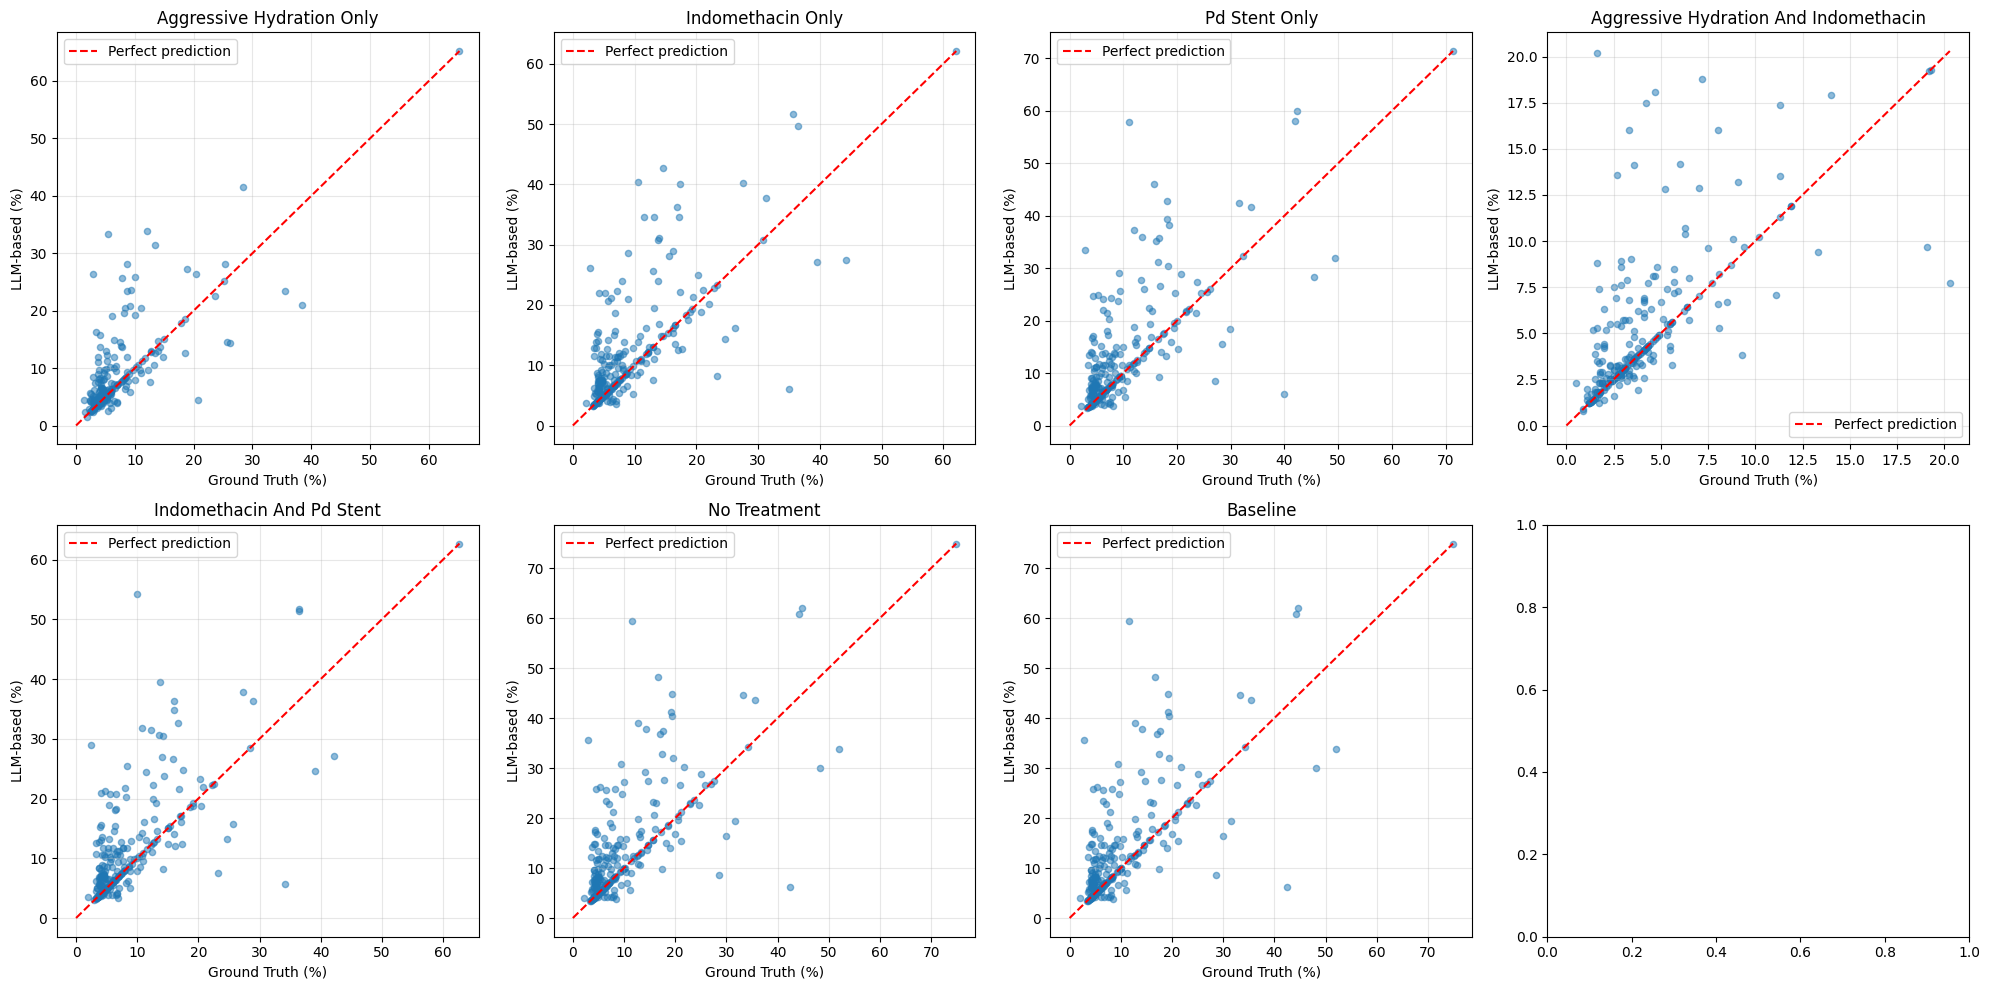

In [ ]:
# Visualize prediction comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(risk_cols):
    gt_col = f"{col}_gt"
    llm_col = f"{col}_llm"
    
    gt_vals = pd.to_numeric(pred_merged[gt_col], errors='coerce')
    llm_vals = pd.to_numeric(pred_merged[llm_col], errors='coerce')
    
    # Scatter plot
    axes[idx].scatter(gt_vals, llm_vals, alpha=0.5, s=20)
    axes[idx].plot([0, max(gt_vals.max(), llm_vals.max())], 
                    [0, max(gt_vals.max(), llm_vals.max())], 
                    'r--', label='Perfect prediction')
    axes[idx].set_xlabel('Ground Truth (%)')
    axes[idx].set_ylabel('LLM-based (%)')
    axes[idx].set_title(col.replace('risk_', '').replace('_pct', '').replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

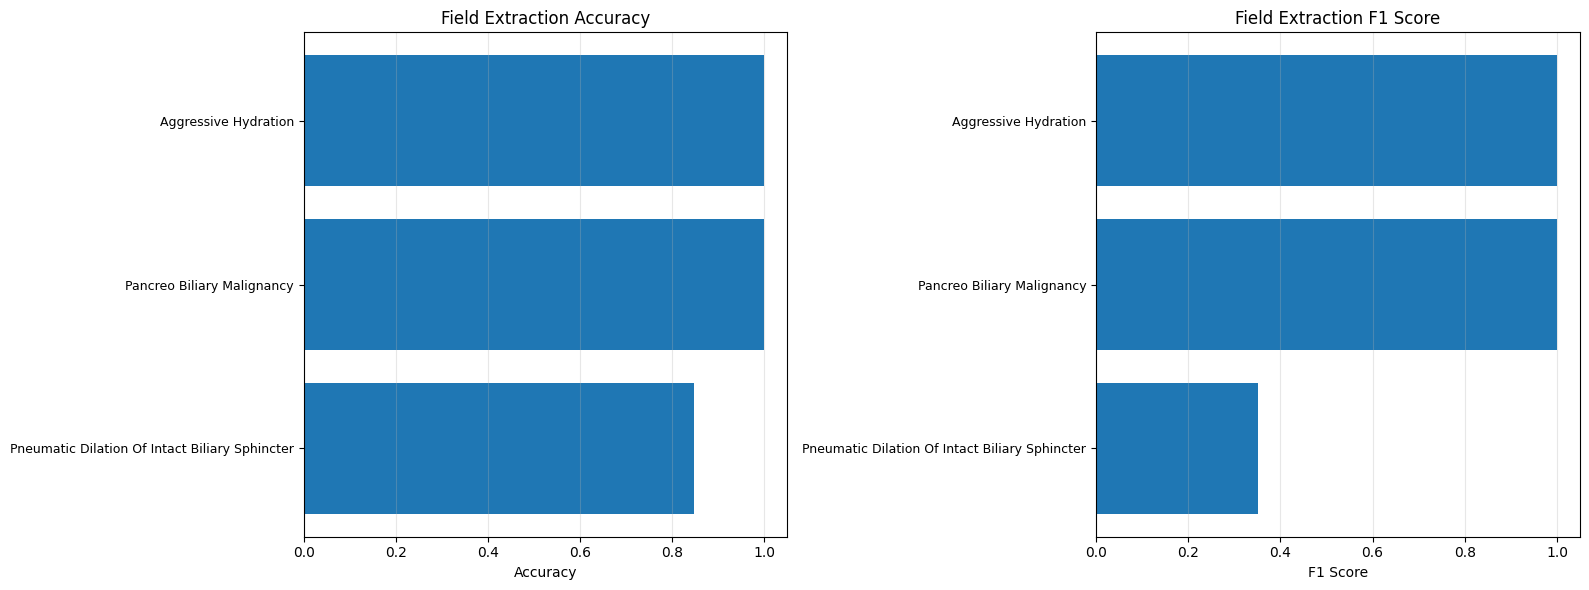

In [ ]:
# Visualize field extraction accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of accuracy by field
field_eval_df_sorted = field_eval_df.sort_values('accuracy')
ax1.barh(range(len(field_eval_df_sorted)), field_eval_df_sorted['accuracy'])
ax1.set_yticks(range(len(field_eval_df_sorted)))
ax1.set_yticklabels(field_eval_df_sorted['field'].str.replace('_', ' ').str.title(), fontsize=9)
ax1.set_xlabel('Accuracy')
ax1.set_title('Field Extraction Accuracy')
# ax1.axvline(x=overall_accuracy, color='r', linestyle='--', label=f'Mean: {overall_accuracy:.3f}')
ax1.grid(True, alpha=0.3, axis='x')

# F1 scores
field_eval_df_sorted_f1 = field_eval_df.sort_values('f1')
ax2.barh(range(len(field_eval_df_sorted_f1)), field_eval_df_sorted_f1['f1'])
ax2.set_yticks(range(len(field_eval_df_sorted_f1)))
ax2.set_yticklabels(field_eval_df_sorted_f1['field'].str.replace('_', ' ').str.title(), fontsize=9)
ax2.set_xlabel('F1 Score')
ax2.set_title('Field Extraction F1 Score')
# ax2.axvline(x=field_eval_df['f1'].mean(), color='r', linestyle='--', label=f'Mean: {field_eval_df["f1"].mean():.3f}')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()